In [2]:
#%%flake8  # checking PEP8 compliance
# Importation des diverses libraires
import re
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import researchpy as rp
from datetime import datetime, timedelta

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import word2vec as w2v
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer

import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')


warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")

pd.set_option('display.max_columns', 100)


%config InlineBackend.figure_format = 'png'
%matplotlib inline

G:\Logiciels\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Loading

In [3]:
df_2018 = pd.read_csv('StackExchange_2018_FavCount.csv')
df_2019 = pd.read_csv('StackExchange_2019_FavCount.csv')
df_2020 = pd.read_csv('StackExchange_2020_FavCount.csv')

In [4]:
df_full = df_2018.append(df_2019.append(df_2020,
                                        ignore_index=True),
                         ignore_index=True)

In [5]:
df_full.head(2)

,Id,CreationDate,AcceptedAnswerId,Body,Title,Tags
0,50649795,2018-06-01 19:15:52,51955400,<p>I’m using Roslyn CSharpCompilation to gener...,How to debug dll generated from Roslyn compila...,<c#><debugging><visual-studio-2017><roslyn>
1,50649831,2018-06-01 19:18:45,50650072,<p>I am trying to understand why regularizatio...,Understanding Regularization in Keras,<python><keras>


In [6]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                55000 non-null  int64 
 1   CreationDate      55000 non-null  object
 2   AcceptedAnswerId  55000 non-null  int64 
 3   Body              55000 non-null  object
 4   Title             55000 non-null  object
 5   Tags              55000 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.5+ MB


# Text preparation

### Tags

In [7]:
# Splitting tags and removing some of the special characters <, >, .x, etc...
df_full["Tags_stripped"] = [re.sub('-',
                                   ' ',
                                   text) for text in df_full["Tags"]]
df_full["Tags_stripped"] = [re.sub(r'' '\d+',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'' '\.x',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r's\.',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'' '\d+',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'\d+$',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'\.$',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'\d+',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'' '$',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'\.x$',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(r'' '$',
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(" >",
                                   ">",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub("><",
                                   ", ",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub("<",
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(">",
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = [re.sub(" \. ",
                                   "",
                                   text) for text in df_full["Tags_stripped"]]
df_full["Tags_stripped"] = df_full["Tags_stripped"].str.split(", ")
df_full["Tags_stripped"] = [list(set(words)) 
                            for words in df_full["Tags_stripped"]]

In [8]:
df_full.head(2)

,Id,CreationDate,AcceptedAnswerId,Body,Title,Tags,Tags_stripped
0,50649795,2018-06-01 19:15:52,51955400,<p>I’m using Roslyn CSharpCompilation to gener...,How to debug dll generated from Roslyn compila...,<c#><debugging><visual-studio-2017><roslyn>,"[roslyn, debugging, c#, visual studio]"
1,50649831,2018-06-01 19:18:45,50650072,<p>I am trying to understand why regularizatio...,Understanding Regularization in Keras,<python><keras>,"[python, keras]"


In [9]:
tags_synonyms = pd.read_csv("StackExchange_Synonyms.csv")

In [10]:
tags_synonyms.head(4)

,Id,SourceTagName,TargetTagName
0,3,windows-forms,winforms
1,5,c-sharp,c#
2,7,hg,mercurial
3,9,dotnet,.net


In [11]:
tags_synonyms.shape

(4856, 3)

In [12]:
#Replacing Synonyms
for ind, tags in enumerate(df_full["Tags_stripped"]):
    for num, tag in enumerate(tags):
        if tag in list(tags_synonyms["SourceTagName"]):
            df_full["Tags_stripped"].loc[ind][num] = \
                tags_synonyms["TargetTagName"][np.where(
                    tags_synonyms["SourceTagName"] == tag)[0][0]]

In [13]:
toptags = pd.Series(np.concatenate(
    [tag for tag in df_full["Tags_stripped"]])).value_counts()

In [14]:
toptags

python                8182
javascript            5230
java                  4654
android               3373
c#                    2817
                      ... 
countries                1
member pointers          1
react native image       1
sre                      1
cascade classifier       1
Length: 13144, dtype: int64

(0, 100)

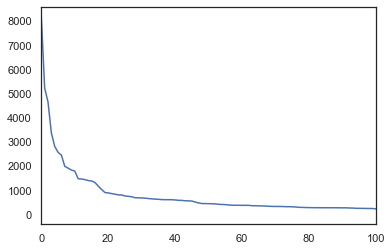

In [15]:
plt.plot(range(len(toptags)),
         toptags.values)
plt.xlim(0, 100)

In [16]:
len(toptags[toptags >= toptags.max()/100])

275

In [17]:
it_tags_dict = toptags[toptags >= toptags.max()/100].index

### Conversion - Removing HTML tags

In [18]:
df_full["Title_Body"] = [re.sub("\\n",
                                " ",
                                title +
                                " " +
                                BeautifulSoup(
                                    body,
                                    "html.parser").get_text().lower())
                         for title, body in zip(df_full["Title"],
                                                df_full["Body"])]

### Stop words

In [19]:
words_to_remove = list(pd.Series(
    pd.read_csv("my_stop_words.csv",
                header=None)[0]).values)

In [20]:
sw = set()
sw.update(words_to_remove)
sw.update(tuple(stopwords.words('english')))

In [21]:
to_space = re.compile('[/(){}\[\]\|\@,;:\-_\*]')
to_keep_ = re.compile('[^a-z #+.]')
to_remove = list(sw)

In [22]:
class WordReplacer(object):
    def __init__(self, word_map):
        self.word_map = word_map

    def replace(self, word):
        return self.word_map.get(word, word)

In [23]:
replacer = WordReplacer(
    pd.DataFrame(tags_synonyms.drop(columns=["Id"])
                 .to_dict('split')["data"])
    .set_index(0).to_dict()[1])

In [24]:
#Text processing, removing stopwords, numerics, some special characters, web links
#Generic web link cannot be flake8
for ind in df_full.index:
    text = df_full["Title_Body"].loc[ind]
    text = text.lower()
    text = re.sub("\\n",
                  " ",
                  text)
    text = re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)',
                  '',
                  text,
                  flags=re.MULTILINE)
    text = re.sub(r'http?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)',
                  '',
                  text,
                  flags=re.MULTILINE)
    text = " ".join([str(replacer.replace(words)) for words in text.split()])
    text = re.sub(to_space,
                  " ",
                  text)
    text = re.sub(to_keep_,
                  " ",
                  text)
    text = re.sub("\.\n",
                  " ",
                  text)
    text = re.sub("\. ",
                  " ",
                  text)
    text = " ".join([words for words in text.split()
                     if (words not in to_remove)])
    df_full.at[ind, "Text"] = text

In [25]:
df_full.head(2)

,Id,CreationDate,AcceptedAnswerId,Body,Title,Tags,Tags_stripped,Title_Body,Text
0,50649795,2018-06-01 19:15:52,51955400,<p>I’m using Roslyn CSharpCompilation to gener...,How to debug dll generated from Roslyn compila...,<c#><debugging><visual-studio-2017><roslyn>,"[roslyn, debugging, c#, visual studio]",How to debug dll generated from Roslyn compila...,debugging dll roslyn compilation roslyn csharp...
1,50649831,2018-06-01 19:18:45,50650072,<p>I am trying to understand why regularizatio...,Understanding Regularization in Keras,<python><keras>,"[python, keras]",Understanding Regularization in Keras i am try...,regularization keras regularization keras roug...


In [26]:
df_full["Tags_in_IT_dict"] = " "
for ind in df_full.index:
    tags_in_dict = []
    for tags in df_full["Tags_stripped"].loc[ind]:
        if tags in it_tags_dict.values:
            tags_in_dict.append(tags)
    df_full.at[ind, "Tags_in_IT_dict"] = tags_in_dict

In [27]:
df_full.drop(columns=["Id",
                      "CreationDate",
                      "AcceptedAnswerId",
                      "Body",
                      "Title",
                      "Tags"],
             inplace=True)

In [32]:
for ind in df_full.index:
    for tagz in pd.Series(df_full["Tags_stripped"].loc[ind]).str.split():
        if len(tagz) > 1:
            for tag in tagz:
                if ((tag not in df_full["Tags_in_IT_dict"].loc[ind])
                    & (tag in it_tags_dict)):
                    df_full["Tags_in_IT_dict"].loc[ind].append(tag)

In [ ]:
pd.Series(it_tags_dict).to_hdf('it_dict_syno.h5',
                               key='df',
                               mode="w")

In [ ]:
pd.Series(it_tags_dict).to_csv('it_dict_syno.csv',
                               header=False,
                               index=False)

In [ ]:
df_full.to_hdf('dataframe_syno_01.h5',
               key='dataframe',
               mode='w')

# Visualisation

In [ ]:
df = pd.read_hdf('dataframe_syno_01.h5')
it_tags_dict = pd.read_hdf('it_dict_syno.h5').values
df.info()

In [33]:
df = df_full.copy()

In [34]:
df.head()

,Tags_stripped,Title_Body,Text,Tags_in_IT_dict
0,"[roslyn, debugging, c#, visual studio]",How to debug dll generated from Roslyn compila...,debugging dll roslyn compilation roslyn csharp...,"[debugging, c#, visual studio]"
1,"[python, keras]",Understanding Regularization in Keras i am try...,regularization keras regularization keras roug...,"[python, keras]"
2,"[image, python imaging library, imaging, jpeg,...",Spot the difference between these two images p...,spot programmatically detecting always rejecti...,"[image, image processing, python]"
3,"[reactjs, material ui, html]",Disable the collapse action from a Material-UI...,disable collapse action material ui stepper bu...,"[reactjs, material ui, html]"
4,"[haskell, haskell stack, cabal]","stack build results in ""output was redirected ...",stack redirected relevant google stack buildin...,[haskell]


In [35]:
df["count"] = df["Text"].str.split().str.len()

In [36]:
max(df["count"])

3042

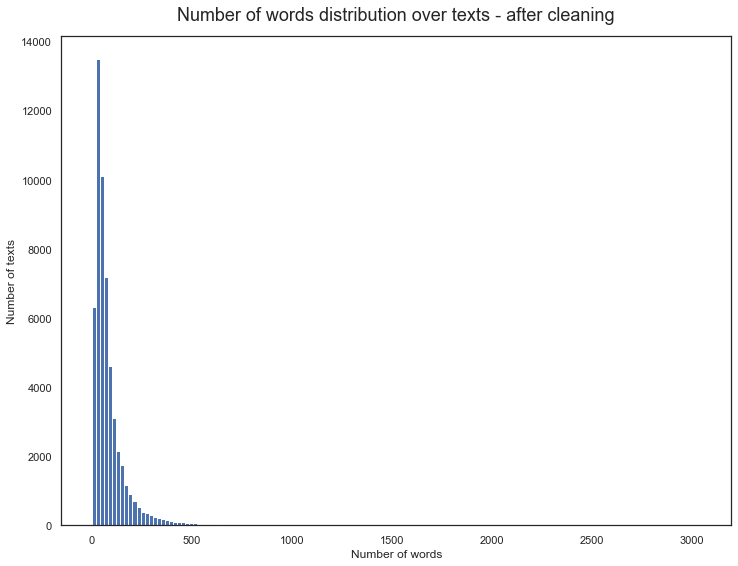

In [37]:
df['count'].plot(kind='hist',
                 bins=150,
                 figsize=(12, 9))
plt.xlabel('Number of words')
plt.ylabel('Number of texts')
plt.title('Number of words distribution over texts - after cleaning',
          y=1.02,
          fontsize=18)
plt.show()

In [38]:
len(df[df["count"] > 546])/len(df)

0.009927272727272727

In [39]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, ind])
                  for word, ind in vec.vocabulary_.items()]
    words_freq = pd.DataFrame(words_freq, columns=["word", "freq"])
    words_freq.set_index("word", inplace=True)
    return words_freq.sort_values(by="freq", ascending=False)[:n]

In [40]:
most_common_w = get_top_n_words(df["Text"],
                                100)

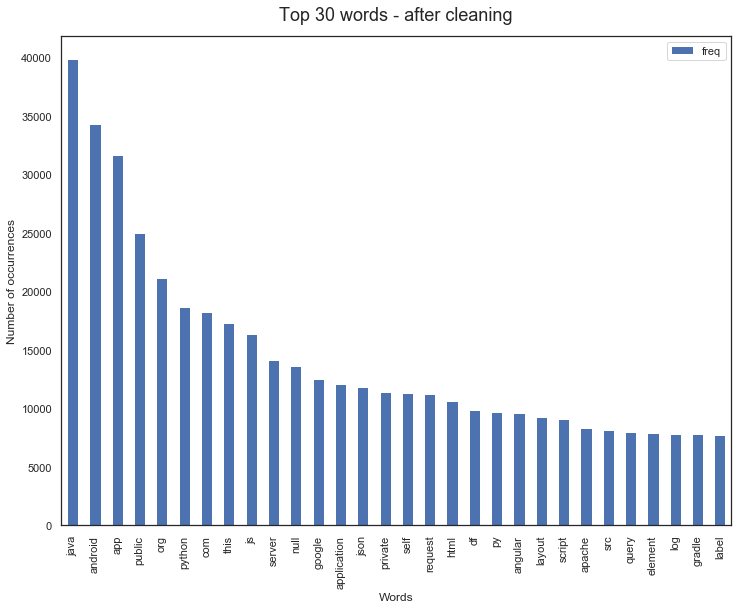

In [41]:
most_common_w[0:30].plot(kind='bar',
                         figsize=(12, 9))
plt.xlabel('Words')
plt.ylabel("Number of occurrences")
plt.title('Top 30 words - after cleaning',
          y=1.02,
          fontsize=18)
plt.show()

In [42]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2),
                          stop_words=sw).fit(corpus)
    bow = vec.transform(corpus)
    sum_words = bow.sum(axis=0)
    words_freq = [(word, sum_words[0, ind])
                  for word, ind in vec.vocabulary_.items()]
    words_freq = pd.DataFrame(words_freq, columns=["word", "freq"])
    words_freq.set_index("word", inplace=True)
    return words_freq.sort_values(by="freq", ascending=False)[:n]

In [43]:
most_common_bi = get_top_n_bigram(df["Text"], 100)

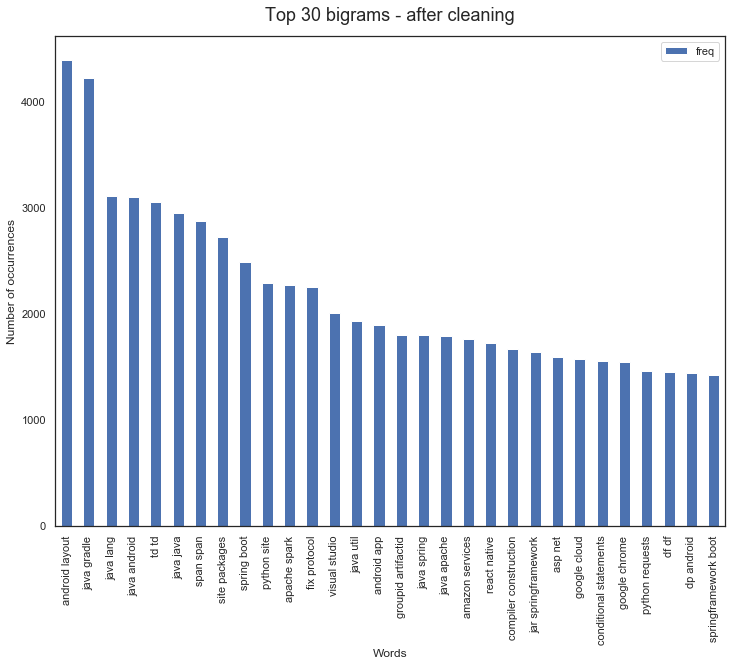

In [44]:
most_common_bi[:30].plot(kind='bar', figsize=(12, 9))
plt.xlabel('Words')
plt.ylabel("Number of occurrences")
plt.title('Top 30 bigrams - after cleaning', y=1.02, fontsize=18)
plt.show()

# Lemmatisation / Racinisation

In [45]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stem_porter = nltk.stem.PorterStemmer()
stem_lanca = nltk.stem.LancasterStemmer()

for ind in df.index:
    df.at[ind, 'Text_lemmatized'] = lemmatizer.lemmatize(df["Text"].loc[ind])
    df.at[ind, 'Text_stem_porter'] = stem_porter.stem(df["Text"].loc[ind])
    df.at[ind, 'Text_stem_lanca'] = stem_lanca.stem(df["Text"].loc[ind])

In [46]:
df.head()

,Tags_stripped,Title_Body,Text,Tags_in_IT_dict,count,Text_lemmatized,Text_stem_porter,Text_stem_lanca
0,"[roslyn, debugging, c#, visual studio]",How to debug dll generated from Roslyn compila...,debugging dll roslyn compilation roslyn csharp...,"[debugging, c#, visual studio]",39,debugging dll roslyn compilation roslyn csharp...,debugging dll roslyn compilation roslyn csharp...,debugging dll roslyn compilation roslyn csharp...
1,"[python, keras]",Understanding Regularization in Keras i am try...,regularization keras regularization keras roug...,"[python, keras]",96,regularization keras regularization keras roug...,regularization keras regularization keras roug...,regularization keras regularization keras roug...
2,"[image, python imaging library, imaging, jpeg,...",Spot the difference between these two images p...,spot programmatically detecting always rejecti...,"[image, image processing, python]",296,spot programmatically detecting always rejecti...,spot programmatically detecting always rejecti...,spot programmatically detecting always rejecti...
3,"[reactjs, material ui, html]",Disable the collapse action from a Material-UI...,disable collapse action material ui stepper bu...,"[reactjs, material ui, html]",31,disable collapse action material ui stepper bu...,disable collapse action material ui stepper bu...,disable collapse action material ui stepper bu...
4,"[haskell, haskell stack, cabal]","stack build results in ""output was redirected ...",stack redirected relevant google stack buildin...,[haskell],198,stack redirected relevant google stack buildin...,stack redirected relevant google stack buildin...,stack redirected relevant google stack buildin...


In [59]:
df.drop(columns=["Title_Body", "count"], inplace=True)
df.to_hdf("dataframe_clean.h5", key="dataframe", mode="w")